In [2]:
import pandas as pd
import numpy as np
import random 
import re                                        ## regular expression 
import nltk

from nltk.corpus import stopwords                ## stopwords
from nltk.tokenize import word_tokenize          ## tokenize words
from nltk.stem import WordNetLemmatizer          ## lemmatize words


import imblearn                                  ## oversampling
import imblearn.over_sampling
from imblearn.over_sampling import SMOTE

import sklearn
from sklearn.ensemble import RandomForestClassifier## randomforest
from sklearn.metrics import confusion_matrix                
from sklearn.model_selection import train_test_split

import seaborn as sns                            ## heatmap
import matplotlib.pyplot as plt                  ## ploting

/Users/harrisonlee/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
### read csv and drop none records and duplicate apps in df1
### merge df1 and df2
df1 = pd.read_csv("googleplaystore.csv")
df1 = df1.dropna()
df1 = df1.drop_duplicates(subset='App')
df2 = pd.read_csv("googleplaystore_user_reviews.csv")
df2 = df2.dropna()

In [4]:
idx_i = pd.Index(set(df1['App']))
idx_ii = pd.Index(set(df2['App']))
intersec = sorted(list(idx_ii.intersection(idx_i)))

In [5]:
checkrows = []
for i,r in df2.iterrows() :
    if r['App'] in intersec: 
        checkrows.append(True)
    else: 
        checkrows.append(False)
new_table = df2[checkrows]
new_table = pd.merge(new_table, df1, on="App")

2.6
4.9
4.3


(array([   96.,    63.,   159.,   627.,   804.,  2312.,  9220., 10502.,
         9402.,  2744.]),
 array([2.6 , 2.83, 3.06, 3.29, 3.52, 3.75, 3.98, 4.21, 4.44, 4.67, 4.9 ]),
 <a list of 10 Patch objects>)

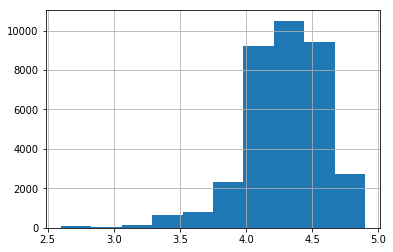

In [6]:
### examine distribution of ratings:
print(pd.DataFrame.min(new_table['Rating']))
print(pd.DataFrame.max(new_table['Rating']))
print(pd.DataFrame.median(new_table['Rating']))
plt.figure
plt.grid()
plt.hist(new_table['Rating'])

In [7]:
### Round up ratings
### Since the data is skewed,
### I decided to change the problem to classification problem. 
### I partitioned ratings by assigning [2.6,3.6) to 3, [3.6,4.5) to 4, and [4.5, 5.0) to 5.0
### which is just shift the 3.5 bound in round() method to 3.6.
midpoint1 = 3.6
midpoint2 = 4.5
# new_table.reset_index(inplace=True)
labels = []
for i,r in new_table.iterrows() :
    temp = r["Rating"]
    if  temp < midpoint1: 
        labels.append("3.0")
    elif midpoint1 <= temp and temp < midpoint2: 
        labels.append("4.0")
    elif midpoint1 <= temp and temp < 5.0: 
        labels.append("5.0")
        

new_table["label Rating"] = labels

(array([22838.,     0.,     0.,     0.,     0., 12146.,     0.,     0.,
            0.,   945.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

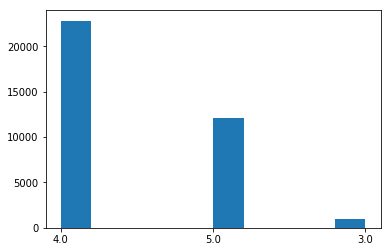

In [8]:
plt.hist(labels)

In [9]:
print("total numbers of apps: " + str(len(intersec)))
print("total numbers of reviews: " + str(len(new_table)))
print("round up ratings: " + str(set(labels)))

total numbers of apps: 816
total numbers of reviews: 35929
round up ratings: {'3.0', '4.0', '5.0'}


In [ ]:
######################################### data preprocessing ######################################### 

In [10]:
data = new_table.copy()
num_reviews = len(data)
    

In [11]:
## step 1: text cleaning

## tokenize words
## remove stop words
## lemmatize words
## correct punctuation
## remove non-English words and single letter 

stop_words = set(nltk.corpus.stopwords.words('english')) 
English_words = set(nltk.corpus.words.words())



def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    reduced_word1 = pattern.sub(r"\1\1", text)
    if reduced_word1 in English_words:   ## words like: "allll"
        return reduced_word1
    else:                                ## words like: "wayyyyy"
        return pattern.sub(r"\1", text)


In [12]:
from nltk.stem import WordNetLemmatizer 

WNL = WordNetLemmatizer() 
WNL.lemmatize("better", pos ="a")

text_list=[]
for i in data.Translated_Review:
    text = re.sub("[^a-zA-Z]"," ",i)
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [w for w in text if not w in stop_words] 
    new_text = []
    for w in text:
        w1 = WNL.lemmatize(w, pos = "n")
        w1 = WNL.lemmatize(w1, pos ="v")
        w1 = WNL.lemmatize(w1, pos ="a")
        w1 = reduce_lengthening(w1) ## correct punctuation             
        if w1 in English_words:     ## check if it is an English word
            new_text.append(w1)
    text=" ".join([w for w in new_text if len(w)>1]) 
    text_list.append(text)

In [13]:
## step 2: construct a TF_IDF matrix 

## input param: word: string; text: list of string; allWordDict: dictionary of all words with num of documents
## output param: TF_IDF value
## the function assign highest value to high frequent words in a setence but has low frequency in corpus 
## assign lower value to low frequent words in a setence or words with high frequency in corpus 
## assign lowest value to high frequent words in a setence with high frequency in corpus 
## thus the method distinguish high frequent words in some setences and also reduce most common words

def TF_IDF(word, text, allWordDict) :
    wordCT = 0.
    textLen = len(text)
    for i in range(textLen) :
        if text[i] == word:
            wordCT += 1.
    TF = wordCT / textLen
    occur = allWordDict[word]
    IDF = np.log(float(num_reviews)/occur)
    return TF*IDF


In [14]:
## construct a word dictionary: word as key, num_documents as value (11/6)
unsortedDict = {}
for text in text_list:
    doc_i = text.split(" ")
    doc_i = list(set(doc_i))
    for word in doc_i:
        if word not in unsortedDict: unsortedDict[word] = 1
        else : unsortedDict[word] += 1
tupleList = sorted(unsortedDict.items(), key=lambda x:(-x[1],x[0]))
allWordDict = {item[0]: item[1] for item in tupleList}


In [15]:
## TFIDF matrix
TFIDF = np.zeros((num_reviews, len(allWordDict)))

temp = []
for i,v1 in enumerate(text_list) : 
    doc_i = text_list[i].split(" ")
    for word in doc_i:
        freq = TF_IDF(word, doc_i, allWordDict)
        temp.append(freq)
        j = list(allWordDict.keys()).index(word)
        TFIDF[i,j] = freq

In [16]:
## sum up columns: use highest 1000 value for prediction 
colSum = TFIDF.sum(axis = 0)
allTerms = list(allWordDict.keys())
unsortedTerms = {}
for i,v in enumerate(colSum) :
    unsortedTerms[allTerms[i]] = v 
tupleList = sorted(unsortedTerms.items(), key=lambda x:(-x[1],x[0]))        
frequentTerm = {item[0]: item[1] for item in tupleList}
del(frequentTerm[''])
attrName = list(frequentTerm.keys())[:1000]

col_idices = []

for i in range(len(attrName)) :
    idx = allTerms.index(attrName[i])
    col_idices.append(idx)

x = np.zeros(shape=(num_reviews, len(attrName)))
for i,v in enumerate(col_idices) :
    x[:, i] = TFIDF[:, v]

In [ ]:
######################################### model fitting and training ######################################### 

## 0. without resampling

acc:  0.7630114110770944


[Text(0, 0.5, '3'), Text(0, 1.5, '4'), Text(0, 2.5, '5')]

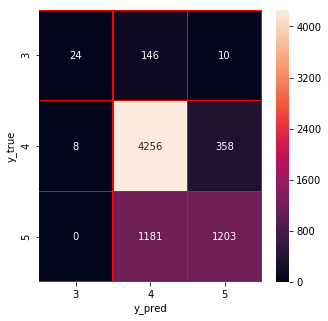

In [18]:
y = new_table['label Rating'].values
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size = 0.2,random_state = 1)


rf = RandomForestClassifier(n_estimators = 30, random_state=42)
rf.fit(xtrain,ytrain)
print("acc: ",rf.score(xtest,ytest))
y_pred=rf.predict(xtest)

names = ['3','4','5']
cm = confusion_matrix(ytest,y_pred)
f,ax = plt.subplots(figsize = (5,5))
cmplot0 = sns.heatmap(cm,annot = True,linewidth =.5,linecolor = "r",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)

In [19]:

###  ---- resampling ----  ###

## explanation: 
## Since the package does not allow to choose the resample size for minority class and it will generate samples as many as label '4.0', 
## I will remove label '4.0' when resampling so that the sampling size of '3.0' will be the same as '5.0'.
## Therefore, the predictive power of the model will be balanced.

idices4 = np.where(ytrain=='4.0')[0]
idices_keep = np.setdiff1d(range(len(ytrain)), idices4)
xtrain_new = []
ytrain_new = []
for idx in idices_keep:
    xtrain_new.append(xtrain[idx])
    ytrain_new.append(ytrain[idx])
xtrain_4 = []
ytrain_4 = []
for idx in idices4:
    xtrain_4.append(xtrain[idx])
    ytrain_4.append(ytrain[idx])
    
xtrain_new = np.array(xtrain_new)
ytrain_new = np.array(ytrain_new)   
xtrain_4 = np.array(xtrain_4)
ytrain_4 = np.array(ytrain_4)   
    
### 1. The first method is to use SMOTE to resample data 
seed = 100
smote = SMOTE(k_neighbors=10, random_state=seed)
x_resampled, y_resampled = smote.fit_sample(xtrain_new, ytrain_new)
x_resampled = np.concatenate((x_resampled, xtrain_4))
y_resampled = np.concatenate((y_resampled, ytrain_4))


acc:  0.7561925967158364


[Text(0, 0.5, '3'), Text(0, 1.5, '4'), Text(0, 2.5, '5')]

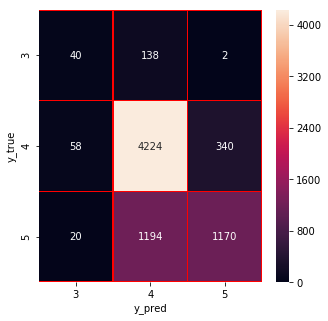

In [20]:
rf = RandomForestClassifier(n_estimators = 30, random_state=42)
rf.fit(x_resampled,y_resampled)
print("acc: ",rf.score(xtest,ytest))
y_pred=rf.predict(xtest)

names = ['3','4','5']
cm = confusion_matrix(ytest,y_pred)
f,ax = plt.subplots(figsize = (5,5))
cmplot0 = sns.heatmap(cm,annot = True,linewidth =.5,linecolor = "r",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)

acc:  0.7542443640411912


[Text(0, 0.5, '3'), Text(0, 1.5, '4'), Text(0, 2.5, '5')]

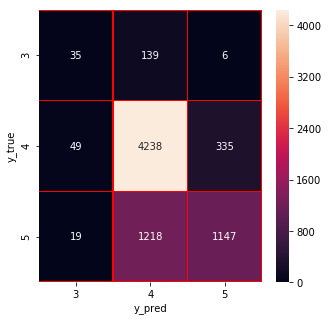

In [21]:
## 2. second method is to use Random Repeated Resampling to resample "3.0"
## explanation: 
## Resample xtrain ytrain with label "3.0" so that the ratio of "3.0" label to total training set is 35 percent 


x_rating3 = []
for i,v in enumerate(xtrain):
    if ytrain[i] == '3.0':
        x_rating3.append(v)

length =  int(len(xtrain)*(0.35)-len(x_rating3))

resample_x = [None]*length
resample_y = ['3.0']*length
idices = list(range(0,len(x_rating3)))
for i in range(length):
    idx = random.choice(idices)
    resample_x[i] = x_rating3[idx]

xtrain = np.concatenate((xtrain, resample_x))
ytrain = np.concatenate((ytrain, resample_y))  

###  ---- model fitting ----  ###
rf = RandomForestClassifier(n_estimators = 30, random_state=42)
rf.fit(xtrain,ytrain)
print("acc: ",rf.score(xtest,ytest))
y_pred=rf.predict(xtest)

names = ['3','4','5']
cm = confusion_matrix(ytest,y_pred)
f,ax = plt.subplots(figsize = (5,5))
cmplot = sns.heatmap(cm,annot = True,linewidth =.5,linecolor = "r",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)


In [23]:
######################################### Feature selection improvements ######################################### 
## Using Lasso to improve feature selection 


In [98]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel

y = new_table["label Rating"].values
xtrain, xtest, ytrain, ytest = train_test_split(TFIDF,y,test_size = 0.2,random_state = 1)

sel_ = SelectFromModel(LogisticRegression(C=1, solver='saga',multi_class= 'multinomial', penalty='l1'), max_features=1000)
sel_.fit(xtrain, ytrain)


/Users/harrisonlee/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                             fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100,
                                             multi_class='multinomial',
                                             n_jobs=None, penalty='l1',
                                             random_state=None, solver='saga',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=1000, norm_order=1, prefit=False, threshold=None)

In [99]:
arr = sel_.get_support()
length = 1000
num_xtrain = len(xtrain)
num_xtest = len(xtest)
new_xtrain = np.zeros((num_xtrain,length))
new_xtest = np.zeros((num_xtest, length))

j = 0
for i,v in enumerate(arr) :
    if v==True:
        new_xtrain[:, j] = xtrain[:, i]
        new_xtest[:, j] = xtest[:, i]
        j+=1


acc:  0.7339270804341775


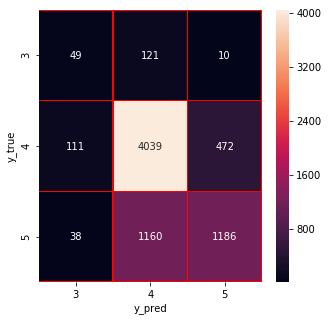

In [100]:

idices4 = np.where(ytrain=='4.0')[0]
idices_keep = np.setdiff1d(range(len(ytrain)), idices4)
xtrain_new = []
ytrain_new = []
for idx in idices_keep:
    xtrain_new.append(new_xtrain[idx])
    ytrain_new.append(ytrain[idx])
xtrain_4 = []
ytrain_4 = []
for idx in idices4:
    xtrain_4.append(new_xtrain[idx])
    ytrain_4.append(ytrain[idx])
    
xtrain_new = np.array(xtrain_new)
ytrain_new = np.array(ytrain_new)   
xtrain_4 = np.array(xtrain_4)
ytrain_4 = np.array(ytrain_4)   
    
### ---- SMOTE resampling ---- ### 
seed = 100
smote = SMOTE(k_neighbors=10, random_state=seed)
x_resampled, y_resampled = smote.fit_sample(xtrain_new, ytrain_new)
x_resampled = np.concatenate((x_resampled, xtrain_4))
y_resampled = np.concatenate((y_resampled, ytrain_4))

        

###  ---- model fitting ---- ### 
  
rf = RandomForestClassifier(n_estimators = 30, random_state=42)
rf.fit(x_resampled,y_resampled)
print("acc: ",rf.score(new_xtest,ytest))
y_pred=rf.predict(new_xtest)

names = ['3','4','5']
cm = confusion_matrix(ytest,y_pred)
f,ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm,annot = True,linewidth =.5,linecolor = "r",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()





# Report

The dataset contains 35929 reviews and 816 distinct apps after I join the two tables. The distribution of the ratings does not appear to be normal, and thus I categorized the data to 3 categories: ratings with 3, 4 and 5. The graph of distribution can be viewed by the code above. 

1. Data preprocessing:

Step1:
I cleaned the text by a sequence of steps often implemented in text mining. First, I tockenize all words, removed all stop words, then lemmatize words, corrected punctuation by reducing length of words, and finally checked if the word appears in nltk word dictionary. These steps removed some common words such as "a" and "the", lemmatized words into base form, and also corrected some punctuations of words such as "wayyyyyy" and "alllllll". The numbers of words across the corpus was reduced to 8385. 

Step2:
Then the text was converted to a term-frequency-inverse-document-frequency(TFIDF) matrix and reduced its dimensionality by ranking of each term. The reason that I chosed the TFIDF model is due to the fact that the model introduces a weighting, the second half of the formula, to penalize frequent words appearing across the corpus. In theory, the method will distinguish high frequent words in some setences and also reduce importance of most common words. Details of the function could be viewed in the code comment above. The final input matrix, therefore, was in a shape of 35929 * 1000.

2. Training and testing model:

Since the model is still highly imbalanced after categorizing each rating (data with label "3.0" is around 3%), I used two methods in imbalanced learning to train the model. The first method is Synthetic Minority Over-sampling Technique (SMOTE), which generates samples according to the k-nearest neighbor of each minority data point: x_new = x_i + lambda*(x_neighbor - x_i). The second method is random resample with replacement. After the generation of resampled data, the ratio of numbers of data with label "3.0" to total amount of data in the training set is 34.8%, which appears to be balanced. The result of random forest model proves this, the prediction accuracy for label "3.0" is highest for the SMOTE method (22.2%), followed by the random resample method (19.4%). By resampling, the result is improved by 6-9 percent compared with no resampling involved(13.3%). The average prediction accuracy of two method is around 75.5%. 

3. Improving feature selection and result:

Last part of this project is implementing LASSO Regression to improve feature selection. Lasso regression adds an penalty term to Residual Sum of Square, applying over the coeffcients. It has the ability to shrink some coefficient to zeros, thus improving feature selection. Here, I selected 1000 features out of 8385, which is the same amount as above (the one simply sums rows of TF-IDF matrix). Despite the final accuracy is dropped, the accuracies of label "3.0" and "5.0" are increased to 27.22% and 49.74% respectively. 


4. Discussion and Conclusion:

The overall prediction accuracy is around 75%. However, the data labeled "3.0" is highly imbalanced, with only 3% to the total dataset. The goal of the project, therefore, becomes to compare different methods to handle an imbalanced dataset. Overall, 3 methods are implemented: SMOTE, random resampling with replacement and LASSO regression. SMOTE and simple random resampling increase the prediction accuracy of label "3.0" by 6-9 percent, and LASSO improves the feature selection and boosts the accuracy of label "3.0" by 5 percent. 


reference:

TFIDF:
https://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html
https://en.wikipedia.org/wiki/Tf%E2%80%93idf


SMOTE oversampling and random resampling:
https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html



